# Comparing Multiple Linear and Non-Linear Regression on MLB Data

Daniel Hassler  
2023-11-14

**Author: Daniel Hassler**

<link rel="stylesheet" type="text/css" href="./index.css">

<a href="https://github.com/hassledw"><i class="fab fa-github"></i></a>
<a href="https://www.linkedin.com/in/daniel-hassler-85027a21a/"><i class="fab fa-linkedin"></i></a>
<!-- Add more social media links/icons as needed -->

In [1]:
```{python}
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
```


## Data

With Kaggle, I was able to find an MLB (Major League Baseball) dataset
consisting of player data from the 1986-1987 seasons
(https://www.kaggle.com/datasets/mathchi/hitters-baseball-data). The
data itself has many features consisting of individual stats for the
season, cumulative career stats, fielding stats, and salary. In total,
there are `20` features with `322` entries before preprocessing.

The goal of this notebook is to showcase linear and non-linear
regression as a way of predicting `salary` (in thousands), a continuous
variable, for my dataset. But before I run through the regression
process, I have to clean the data first and figure out correlations.

One negative influence on regression models is collinearity in the
feature space. Collinearity is problematic for several reasons,
including overfitting, interpretability, and inefficiency. When there
are many features that are highly correlated, this will create a strong
negative impact on the performance. So before plugging into the model, I
analyzed the correlation matrix consisting of correlations between all
the features.

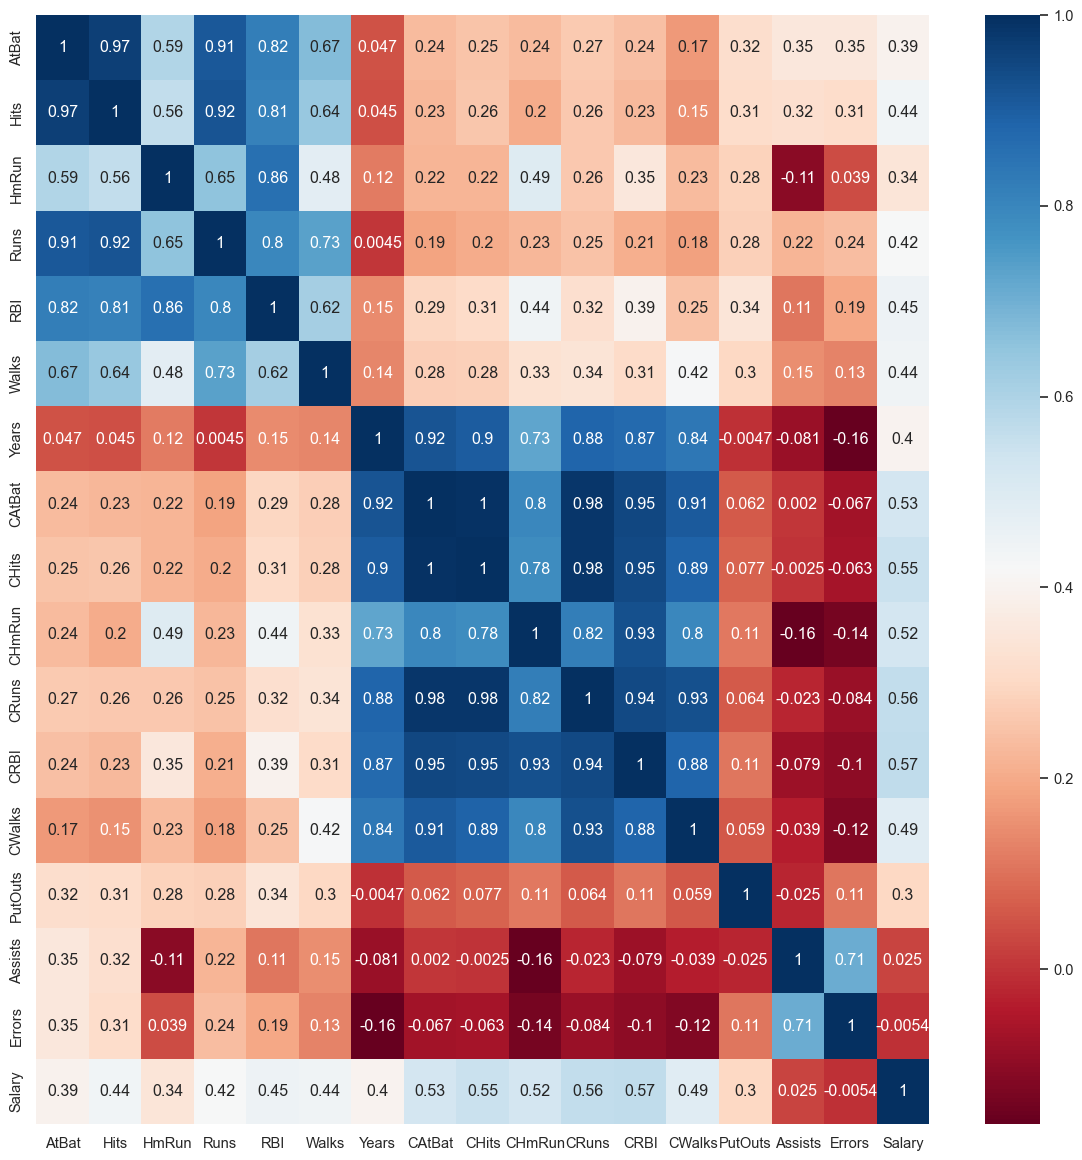

In [2]:
```{python}
df = pd.read_csv("./Hitters.csv")
num_cols = [col for col in df.columns if df[col].dtypes != "O"]
corr = df[num_cols].corr()
sns.set(rc={'figure.figsize': (15, 15)})
sns.heatmap(corr, cmap="RdBu", annot=True)
plt.show()
```


Based on the above correlation matrix, I can see there’s a high
correlation between all the individual season player stats (`AtBat`,
`Hits`, `HmRun`, `Runs`, `RBI`, and `Walks`), cumulative player stats
(`CAtBat`, `CHits`, `CHmRun`, `CRuns`, `CRBI`, `Years`, and `CWalks`),
and finally some fielding stats (`Assists`, `Errors`).

One way to remove these strong correlations is to run a dimensionality
reduction technique. In this case, I will be using PCA (principal
component analysis) seperately on those three highly correlated areas:
individual stats, cumulative stats, and fielding.

In [3]:
```{python}
pca_custat = PCA(n_components=1)
pca_indstat = PCA(n_components=1)
pca_fieldstat = PCA(n_components=1)

custat_df = df[["CAtBat", "CHits", "CHmRun", "CRuns", "CRBI", "CWalks"]]
indstat_df = df[["AtBat", "Hits", "HmRun", "Runs", "RBI", "Walks"]]
fieldstat_df = df[["Assists", "Errors"]]

custat_df_pca = pca_custat.fit_transform(custat_df)
indstat_df_pca = pca_indstat.fit_transform(indstat_df)
fieldstat_df_pca = pca_fieldstat.fit_transform(fieldstat_df)

df_reduced = df.drop(columns=["AtBat", "Hits", "HmRun", "Runs", "RBI", "Walks", "CAtBat", "CHits", "CHmRun", "CRuns", "CRBI", "CWalks", "Assists", "Errors"])
df_reduced = df_reduced.drop(columns=["League", "NewLeague", "Division", "Years"])
df_reduced["I_PC1"] = indstat_df_pca
df_reduced["C_PC2"] = custat_df_pca
df_reduced["F_PC3"] = fieldstat_df_pca

df_reduced.dropna(axis=0, inplace=True)
```


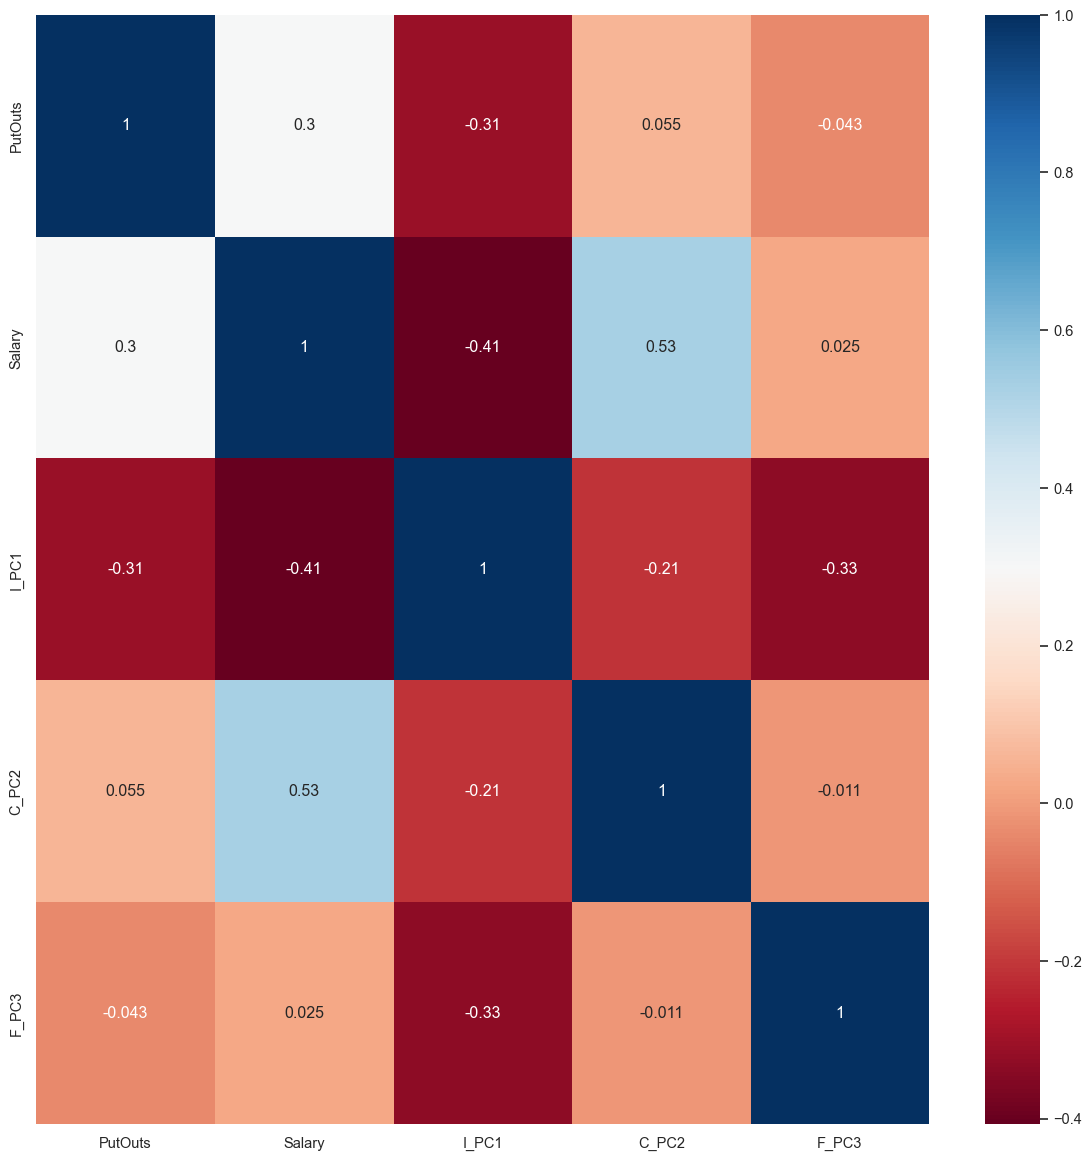

In [4]:
```{python}
num_cols = [col for col in df_reduced.columns if df_reduced[col].dtypes != "O"]
corr = df_reduced[num_cols].corr()
sns.set(rc={'figure.figsize': (15, 15)})
sns.heatmap(corr, cmap="RdBu", annot=True)
plt.show()
```


After applying PCA and removing other features, I’ve reduced the data
from `20` columns to just `5` columns, which is important, as
collinearity can negatively effect the performance of regression models.
Apart from the collinearity effect, I decided to get rid of discretely
labeled binary relationships (labels 0 or 1), as this makes the linear
regression model more complex and can only negatively impact the
performance. I also discarded `years` as a feature because it was highly
correlated with the PCA of the cumulative stats (r=`0.91`).

### Creating the Training and Test Sets

Since we’re trying to predict salary, I extract `salary` column from the
`df_reduced`, storing it into labels array `y`, and dropping that column
from the feature data. The `X` data feature space has dropped from `5`
columns to `4` columns, so there are `4` total features. For splitting
the data into test and train, I am using sklearn’s `train_test_split()`.

In [5]:
```{python}
df = df_reduced
y = df["Salary"]
X = df.drop(columns="Salary")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print(f"Salary STD: ${np.std(y) * 1000:,.2f}")
print(f"Salary Mean: ${np.mean(y) * 1000:,.2f}")
print(f"Salary Low: ${np.min(y) * 1000:,.2f}")
print(f"Salary High: ${np.max(y) * 1000:,.2f}")
```


Salary STD: $450,260.22
Salary Mean: $535,925.88
Salary Low: $67,500.00
Salary High: $2,460,000.00

## Multiple Linear Support Vector Regression (kernel=“linear”)

Now, I will test out multiple linear regression using Sklearn’s `SVR`
(support vector regression) class from the `SVM` library. Before passing
the data into the regression model, I scaled the data using
`StandardScaler()` as this is important for faster computation with
regression. For the hyperparameters, I toyed with different `C` values,
which influences the degree of regularization applied to the SVR model.
A smaller `C` value leads to a simpler model, but a larger `C` value
would fit to the training data more closely, which can potentially
overfit if the number is too high. For the `C` value on the `linear`
kernel, my model showed good preformance at `C=1`.

In [6]:
```{python}
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train, y_train)
X_test_scaled = sc.fit_transform(X_test, y_test)
# pca_all = PCA(n_components=1)
# X_train_scaled_pca = pca_all.fit_transform(X_train_scaled)
# X_test_scaled_pca = pca_all.fit_transform(X_test_scaled)

svr_lin = SVR(kernel="linear", C=1, gamma="auto")
svr_lin.fit(X_train_scaled, y_train)
y_pred = svr_lin.predict(X_test_scaled)
```


### Multiple Linear Regression Visualization

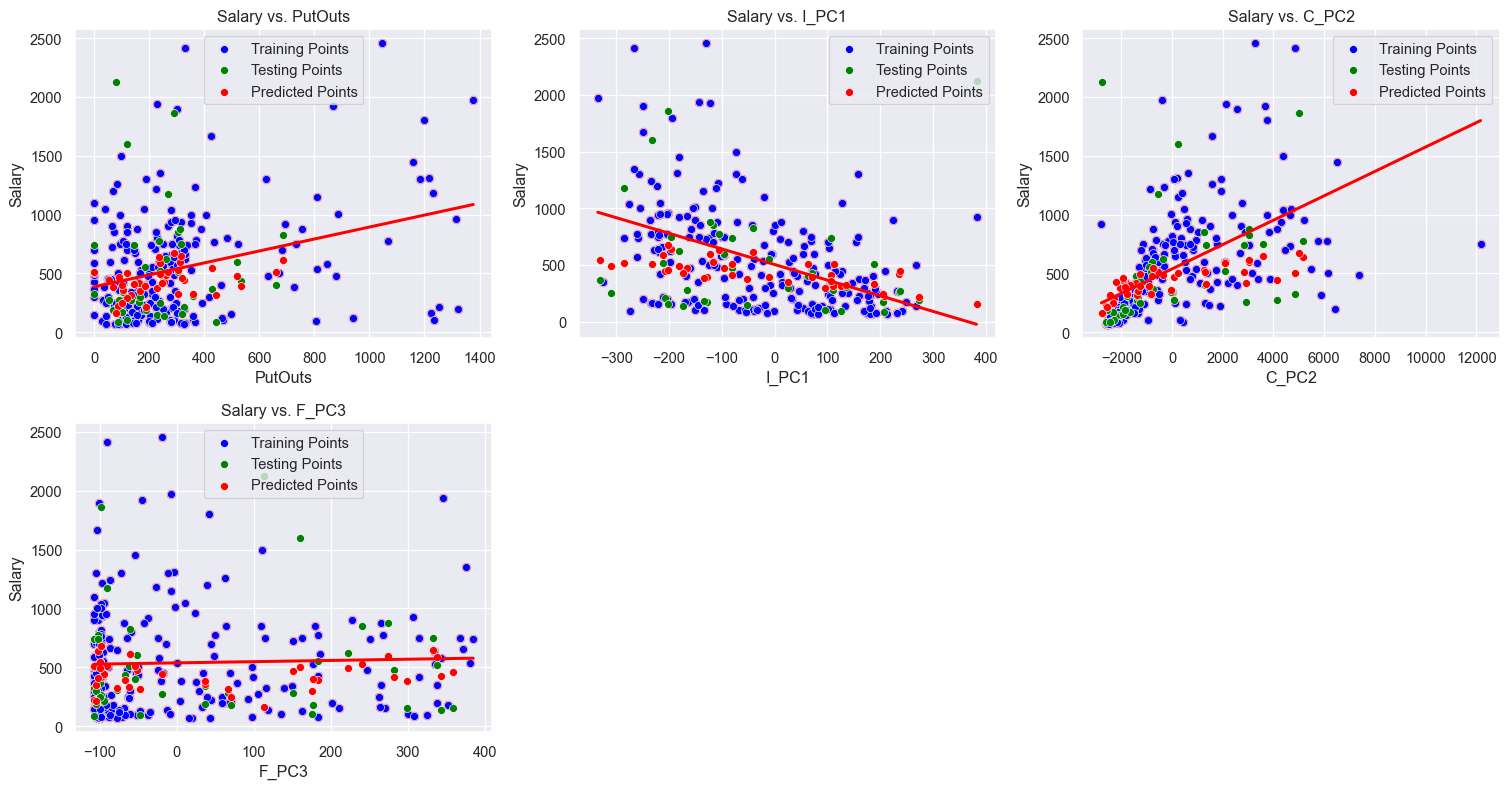

In [7]:
```{python}
plt.figure(figsize=(16, 12))
independent_variables = X_train.columns
dependent_variable = "Salary"
X_test_numpy = X_test.to_numpy()
for i, col in enumerate(independent_variables, 1):
    plt.subplot(3, 3, i)
    sns.regplot(x=X_train[col],y=y_train,ci=None,color ='red')
    sns.scatterplot(data=X_train, x=col, y=y_train, color='blue', label='Training Points')
    sns.scatterplot(data=X_test, x=col, y=y_test, color='green', label='Testing Points')
    sns.scatterplot(data=X_test, x=col, y=y_pred, color='red', label='Predicted Points')
    plt.title(f'{dependent_variable} vs. {col}')
    plt.xlabel(col)
    plt.ylabel(dependent_variable)

plt.tight_layout()
plt.show()
```


Here is a visualization showing linear regression applied on all of the
features in the feature space, which make up the overall prediction. For
each feature, the red line represents the function applied, which in
this case is linear because I’m using a linear kernel, and the points
represent all the different datapoints in the dataset. `X_train` points
are in blue, `X_test` points are in green with their actual label
`y_test`, and predicted points are in red (the `X_test` dataset on the
`y_pred`).

Based on the above visualization, it appears that linear regression
works very well for all the features, although in any case, outliers are
a problem. It is also worth noting that changing the `C` value does
change the results, so modifying that **may** improve preformance with
more fine-tuning. Below, I have outputed some metrics on the model:

In [8]:
```{python}
result_df = pd.DataFrame(columns=["id", "actual", "predicted"])

for i, actual, predicted in zip(y_test.index, y_test, y_pred):
    entry = [i, actual, predicted]
    df_entry = pd.DataFrame(entry, index=["id", "actual", "predicted"]).T
    result_df = pd.concat((result_df, df_entry))
#print(result_df)
difference = abs(result_df["actual"] - result_df["predicted"])
print(f"Cumulative Difference: ${np.sum(difference) * 1000:,.2f}")
print(f"Min Difference: ${np.min(difference) * 1000:,.2f}")
print(f"Max Difference: ${np.max(difference) * 1000:,.2f}")
print(f"Average Difference: ${np.mean(difference) * 1000:,.2f}")
print(f"Std Difference: ${np.std(difference) * 1000:,.2f}")
print(f"Mean Squared Error: ${mean_squared_error(y_test, y_pred):,.2f}")
```


Cumulative Difference: $10,792,084.13
Min Difference: $19,061.95
Max Difference: $1,968,301.30
Average Difference: $269,802.10
Std Difference: $361,894.28
Mean Squared Error: $203,760.65

Based on this data, the total difference (sum of all the differences)
between the actual and predicted outputs could be better, as the average
difference between the labels is around `270` = `$270,000`. The `MSE` is
a common metric used in these types of problems, and my `MSE`(mean
squared error) score is around 205 (`$205,000`), which is a respectable
`MSE` value for this dataset due to its high standard deviation at
(`$450,260.22`).

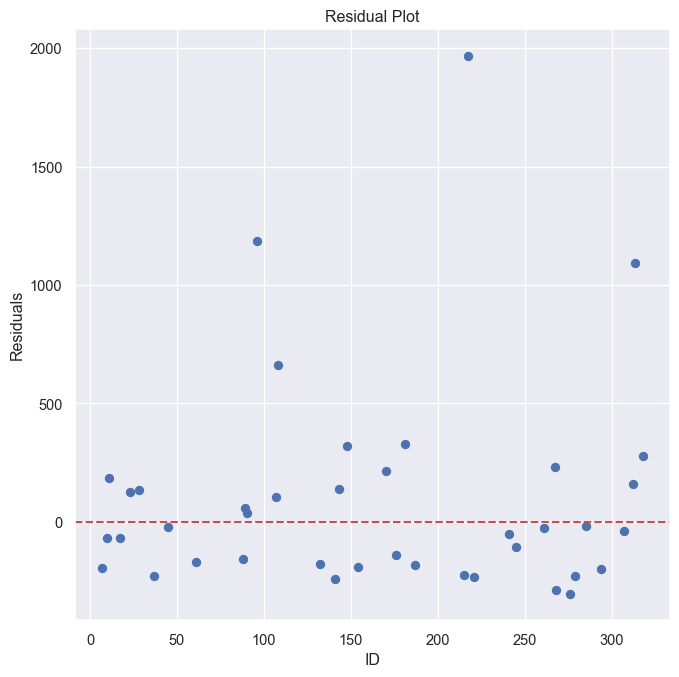

In [9]:
```{python}
plt.figure(figsize=(8,8))
residuals = result_df['actual'] - result_df['predicted']

plt.scatter(result_df['id'], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('ID')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
```


Above is a visualization showing how far the differences are for each
value in the test set (the residuals). `0` means no difference between
the actual and the predicted, any number below `0` means the predicted
value was higher than the actual value, and any number above `0` means
the predicted value was lower than the actual value.

## Multiple Non-Linear Support Vector Regression (kernel=“poly”)

Now I run SVR on a non-linear kernel and assess its comparison to a
linear kernel. Since real world data has a lot of non-linearity, this
comparison is worth attempting.

In [10]:
```{python}
svr_poly = SVR(kernel="poly", degree=2, C=75, gamma="scale")
svr_poly.fit(X_train_scaled, y_train)
y_pred = svr_poly.predict(X_test_scaled)

result_df = pd.DataFrame(columns=["id", "actual", "predicted"])

for i, actual, predicted in zip(y_test.index, y_test, y_pred):
    entry = [i, actual, predicted]
    df_entry = pd.DataFrame(entry, index=["id", "actual", "predicted"]).T
    result_df = pd.concat((result_df, df_entry))
    
#print(result_df)
difference = abs(result_df["actual"] - result_df["predicted"])
print(f"Cumulative Difference: ${np.sum(difference) * 1000:,.2f}")
print(f"Min Difference: ${np.min(difference) * 1000:,.2f}")
print(f"Max Difference: ${np.max(difference) * 1000:,.2f}")
print(f"Average Difference: ${np.mean(difference) * 1000:,.2f}")
print(f"Std Difference: ${np.std(difference) * 1000:,.2f}")
print(f"Mean Squared Error: ${mean_squared_error(y_test, y_pred):,.2f}")
```


Cumulative Difference: $13,385,640.30
Min Difference: $798.03
Max Difference: $1,581,505.51
Average Difference: $334,641.01
Std Difference: $330,986.90
Mean Squared Error: $221,536.94

Based on the model run through with a polynomial kernel, the results are
overall noticeably worse than the linear kernel, but not by a whole lot.
Although, it is worth noting that the `C` value is crucial in this
result. I was trying to balance the trade-off between conforming to the
function and simplicity. For the polynomial degree, I decide to go with
`2`, as `1` is linear and `3` didn’t preform as anticipated, as the
function plotted didn’t represent some of the features as well as `2`.

### Multiple Non-Linear Regression Visualization

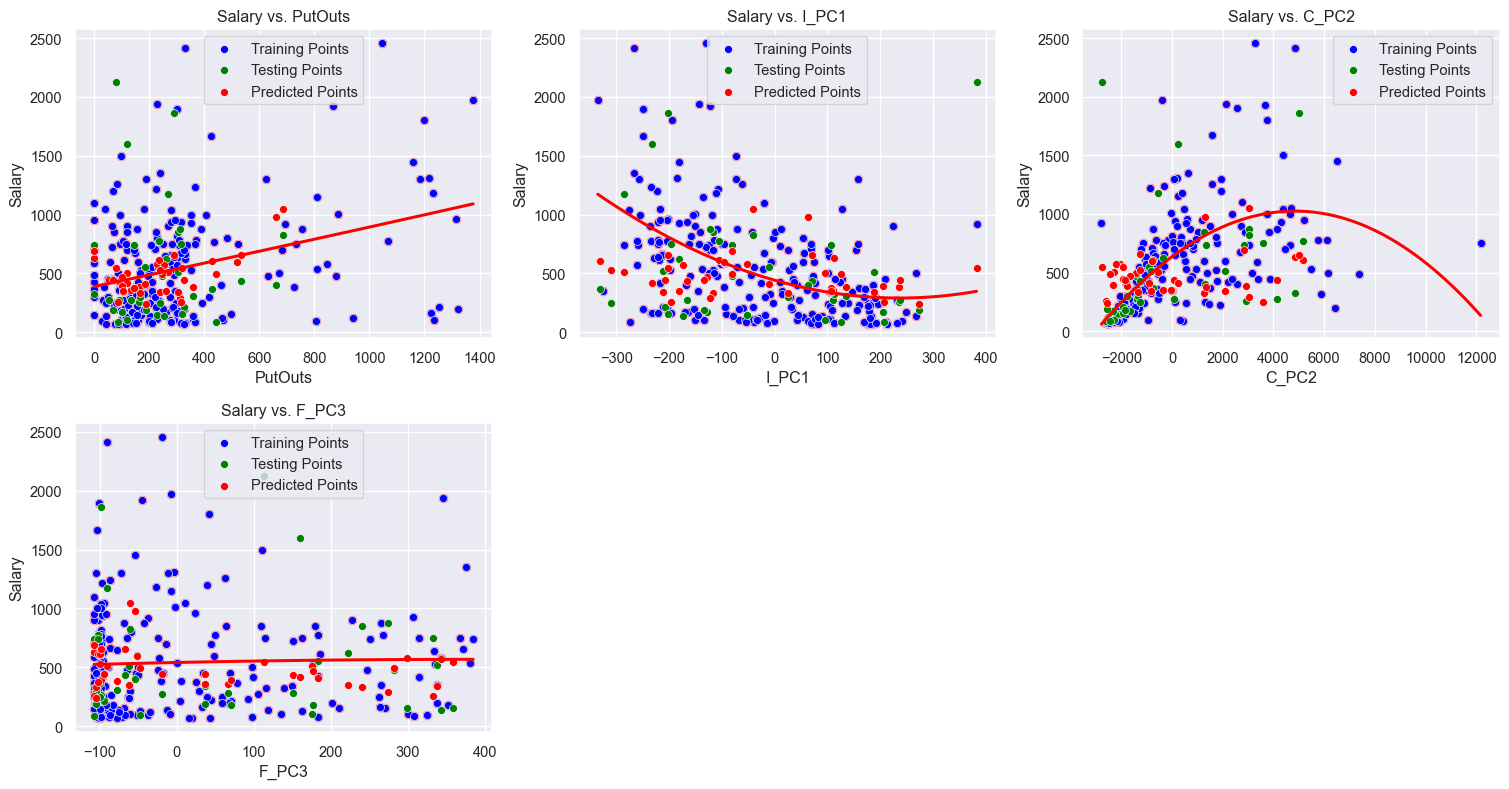

In [11]:
```{python}
plt.figure(figsize=(16, 12))
independent_variables = X_train.columns
dependent_variable = "Salary"
X_test_numpy = X_test.to_numpy()
for i, col in enumerate(independent_variables, 1):
    plt.subplot(3, 3, i)
    sns.regplot(x=X_train[col],y=y_train,ci=None,color ='red', order=svr_poly.degree)
    sns.scatterplot(data=X_train, x=col, y=y_train, color='blue', label='Training Points')
    sns.scatterplot(data=X_test, x=col, y=y_test, color='green', label='Testing Points')
    sns.scatterplot(data=X_test, x=col, y=y_pred, color='red', label='Predicted Points')
    plt.title(f'{dependent_variable} vs. {col}')
    plt.xlabel(col)
    plt.ylabel(dependent_variable)

plt.tight_layout()
plt.show()
```


Based on the above visualzation, using a polynomial function with degree
`2`, shows interesting results. For the `Salary vs PutOuts` plot, the
data plotted resembles a linear kernel, but in actuality it’s a very
zoomed in polynomial kernel. The `Salary vs I_PC1` showed a curve which
I expected. It starts off at a peak and then lowers like a parabolic
function (degree 2). The `Salary vs C_PC2` plot is interesting in the
sense that it’s a negative parabola; I would say this is not a fully
representative curve as it seems to be fitting to the outlier at the end
of the plot. Finally, the `Salary vs F_PC3` plot seems to be similar to
the first plot as it resembles more of a linear kernel.

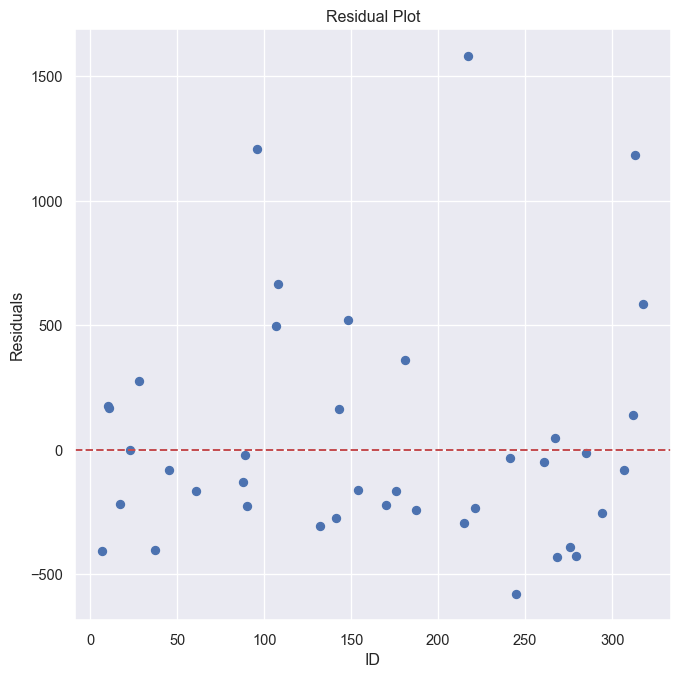

In [12]:
```{python}
plt.figure(figsize=(8,8))
residuals = result_df['actual'] - result_df['predicted']

plt.scatter(result_df['id'], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('ID')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
```


Above is the residual plot for this model with the same setup as the
linear kernel one.

## Discussion and Improvements

In actuality, it appears to me that the `poly` non-linear kernel
represents the data better for certain features even though it doesn’t
perform as well against the `linear` kernel. I believe the tradeoff to
this approach highly depends on the `C` value for both approaches and
requires more hyperparameter awareness and optimization.

In terms of features, I believe all of these features have strong
presuasion in determing an MLB player’s salary, but there is one flaw.
Some players, regardless of preformance, are more “famous” than other
players. It is likely that more famous players have higher salaries
simply because they generate more revenue for the teams they play for,
but that doesn’t necessarily mean the player’s popularity is correlated
with skill. This is the reason why I believe there are outliers in this
dataset. If there were a way to accurately determine popularity, that
would be a key feature in predicting salary as well for this particular
domain. Speaking of outliers, I would also like to point out that
outliers can have a significant impact on these regression models.
Depending on the case, deleting outliers may be a valid option, but that
should come with caution as deleting data can result in loss of valuable
information.